# Factors affeting stundent performance and
# Outcome prediction

#### This project focuses on analyzing student behavior and study patterns with specific objectives. It aims to explore demographic characteristics associated with test success, evaluate study effectiveness, uncover dataset trends, and provide insightful analyses on their implications.

#### Additionally, the project seeks to build a predictive model to forecast students' likelihood of passing the test. The resulting findings will be disseminated, accompanied by recommendations to improve support strategies for helping more students pass. The ultimate goal is to enhance the accuracy of predictive models by leveraging insights gleaned from this research.

## About this dataset

The data was collected from the Faculty of Engineering and Faculty of Educational Sciences students in 2019. The purpose is to predict students' end-of-term performances using ML techniques.

1-10 of the data are the personal questions, 11-16. questions include family questions, and the remaining questions include education habits.

|Column Name| Description|Values|Datatype|
|:------------|:------------|:--------------|:------------------------
|id| Student ID|-|Integer|
|age| Age of the student|1: 18-21, 2: 22-25, 3: above 26|Categorical|
|gender| Gender of the student|1: female, 2: male|Binary|
|hs_type| Graduated high-school type|1: private, 2: state, 3: other|Categorical|
|sch_type| Scholarship type|1: None, 2: 25%, 3: 50%, 4: 75%, 5: Full|Categorical|
|work| Additional work|1: Yes, 2: No|Binary|
|ex_act| Regular artistic or sports activity|1: Yes, 2: No|Binary|
|partner| Do you have a partner |1: Yes, 2: No|Binary|
|salary| Total salary if available|1: USD 135-200, 2: USD 201-270, 3: USD 271-340, 4: USD 341-410, 5: above 410|Categorical|
|transp| Transportation to the university|1: Bus, 2: Private car/taxi, 3: bicycle, 4: Other|Categorical|
|acc_type| Accomodation type in Cyprus|1: rental, 2: dormitory, 3: with family, 4: Other|Categorical|
|mo_edu| Mother's education|1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.|Categorical|
|fa_edu| Father's education|1: primary school, 2: secondary school, 3: high school, 4: university, 5: MSc., 6: Ph.D.|Categorical|
|n_sib| Number of sisters/brothers (if available)|1: 1, 2:, 2, 3: 3, 4: 4, 5: 5 or above|Integer|
|p_stus| Parental status|1: married, 2: divorced, 3: died - one of them or both|Categorical|
|mo_occ| Mother's occupation|1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other|Categorical|
|fa_occ| Father's occupation|1: retired, 2: housewife, 3: government officer, 4: private sector employee, 5: self-employment, 6: other|Categorical|
|w_hours| Weekly study hours|1: None, 2: <5 hours, 3: 6-10 hours, 4: 11-20 hours, 5: more than 20 hours|Categorical|
|frec_nsci| Reading frequency|1: None, 2: Sometimes, 3: Often (non-scientific books/journals)|Categorical|
|frec_sci| Reading frequency|1: None, 2: Sometimes, 3: Often (scientific books/journals)|Categorical|
|att_sem| Attendance to the seminars/conferences related to the department|1: Yes, 2: No|Binary|
|impact| Impact of your projects/activities on your success|1: positive, 2: negative, 3: neutral|Categorical|
|att| Attendance to classes|1: always, 2: sometimes, 3: never|Categorical|
|prep_stus| Preparation to midterm exams 1|1: alone, 2: with friends, 3: not applicable|Categorical|
|prep_reg| Preparation to midterm exams 2|1: closest date to the exam, 2: regularly during the semester, 3: never|Categorical|
|notes| Taking notes in classes|1: never, 2: sometimes, 3: always|Categorical|
|listng| Listening in classes|1: never, 2: sometimes, 3: always|Categorical|
|interest| Discussion improves my interest and success in the course|1: never, 2: sometimes, 3: always|Categorical|
|flip| Flip-classroom|1: not useful, 2: useful, 3: not applicable|Categorical|
|cum_s| Cumulative grade point average in the last semester|1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49|Categorical|
|cum_g| Expected Cumulative grade point average in the graduation|1: <2.00, 2: 2.00-2.49, 3: 2.50-2.99, 4: 3.00-3.49, 5: above 3.49|Categorical|
|course_id| Course ID|-|Integer|
|grade| OUTPUT Grade|0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA|Categorical|


In [162]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [6, 4]

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


# Setting random seed 
RSEED = 42
warnings.filterwarnings("ignore")

##  EDA / Analysis

In [2]:
# Reading data
df = pd.read_csv('data/DATA (1).csv')

In [3]:
df.head()

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


In [4]:
# Renaming columns
col_names = ['id', 'age', 'gender', 'hs_type', 'sch_type', 
             'work', 'ex_act', 'partner', 'salary', 'transp',
             'acc_type', 'mo_edu', 'fa_edu', 'n_sib', 'p_stus',
             'mo_occ', 'fa_occ', 'w_hours', 'frec_nsci', 'frec_sci',
             'att_sem', 'impact', 'att', 'prep_stus', 'prep_reg','notes', 'listng',
              'interest', 'flip', 'cum_s', 'cum_g', 'course_id', 'grade']
df.columns = col_names

df['id'] = df['id'].apply(lambda x: x.strip('STUDENT')).astype(int)


In [5]:
df.head(2)

,id,age,gender,hs_type,sch_type,work,ex_act,partner,salary,transp,...,prep_stus,prep_reg,notes,listng,interest,flip,cum_s,cum_g,course_id,grade
0,1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         145 non-null    int32
 1   age        145 non-null    int64
 2   gender     145 non-null    int64
 3   hs_type    145 non-null    int64
 4   sch_type   145 non-null    int64
 5   work       145 non-null    int64
 6   ex_act     145 non-null    int64
 7   partner    145 non-null    int64
 8   salary     145 non-null    int64
 9   transp     145 non-null    int64
 10  acc_type   145 non-null    int64
 11  mo_edu     145 non-null    int64
 12  fa_edu     145 non-null    int64
 13  n_sib      145 non-null    int64
 14  p_stus     145 non-null    int64
 15  mo_occ     145 non-null    int64
 16  fa_occ     145 non-null    int64
 17  w_hours    145 non-null    int64
 18  frec_nsci  145 non-null    int64
 19  frec_sci   145 non-null    int64
 20  att_sem    145 non-null    int64
 21  impact     145 n

From here we can already see that we don't have missing values

#### Checking unique values

In [7]:
print('Unique values per column:')
print('-' * 15)
df.nunique()
#df.value_counts().count()

Unique values per column:
---------------


id           145
age            3
gender         2
hs_type        3
sch_type       5
work           2
ex_act         2
partner        2
salary         5
transp         4
acc_type       4
mo_edu         6
fa_edu         6
n_sib          5
p_stus         3
mo_occ         5
fa_occ         5
w_hours        5
frec_nsci      3
frec_sci       3
att_sem        2
impact         3
att            2
prep_stus      3
prep_reg       3
notes          3
listng         3
interest       3
flip           3
cum_s          5
cum_g          4
course_id      9
grade          8
dtype: int64

### Impact of Demographic Factors on Performance

- Does age correlate with academic performance?
- Is there a significant difference in performance between male and female students?
- Do students from different high school backgrounds (private, state, other) perform differently?
- How does having a scholarship (and its percentage) affect academic performance?
- Does having additional work affect student performance?

In [8]:
# Gender distribuition
df['gender'].value_counts()

gender
2    87
1    58
Name: count, dtype: int64

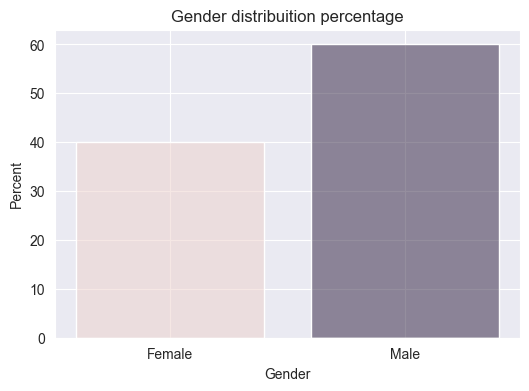

In [11]:
# Gender distribuition

fig = sns.histplot(data=df, x="gender", hue='gender', discrete=True, shrink=.8,
                    legend=False, stat='percent')

plt.title('Gender distribuition percentage')
plt.xticks(np.arange(1, 3, step=1), ['Female', 'Male'])
plt.xlabel('Gender')

plt.show()

Gender is not balanced, there is more male students than females

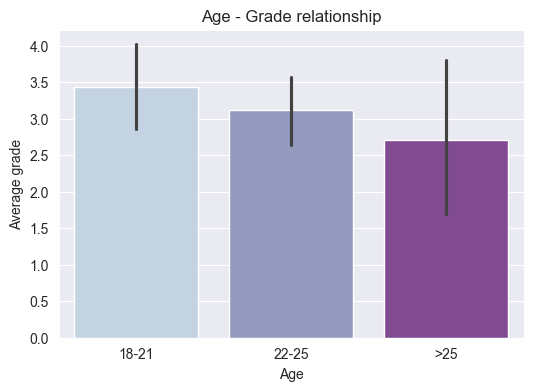

In [33]:
# Age - grades gender

fig = sns.barplot(data=df, x="age", y= 'grade', palette='BuPu')

plt.title('Age - Grade relationship')
plt.xticks(np.arange(0, 3, step=1), ['18-21', '22-25', '>25'])
plt.xlabel('Age')
plt.ylabel('Average grade')
plt.show()

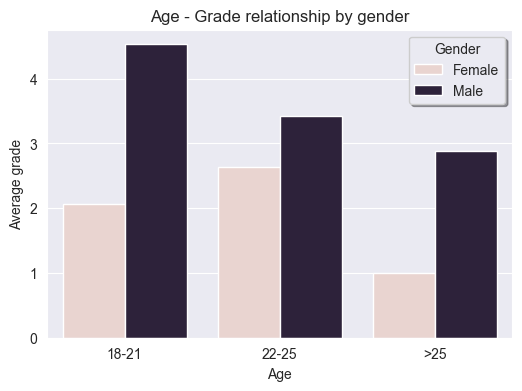

In [10]:
# Age - grades gender

fig = sns.barplot(data=df, x="age", y= 'grade', hue='gender', ci=None)#, estimator='std')

plt.title('Age - Grade relationship by gender')
plt.xticks(np.arange(0, 3, step=1), ['18-21', '22-25', '>25'])
plt.xlabel('Age')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

- Younger students (18-21) tend to achieve better grades. 
- Students aged + 25 are the ones with the lowest grades but there is most likely less students is this group due what it's showned by the error bar
- By gender, females grades are better for the group age 22-25.

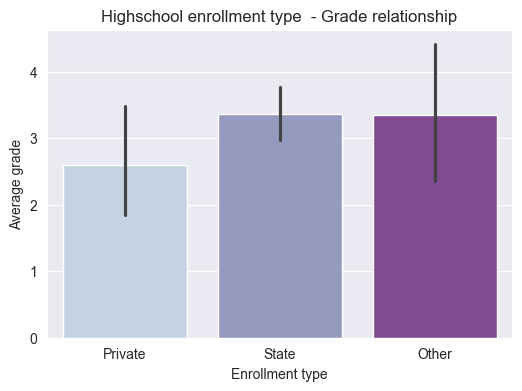

In [43]:
# Highschool - grades 

fig = sns.barplot(data=df, x="hs_type", y= 'grade', palette='BuPu')

plt.title('Highschool enrollment type  - Grade relationship')
plt.xticks(np.arange(0, 3, step=1), ['Private', 'State', 'Other'])
plt.xlabel('Enrollment type')
plt.ylabel('Average grade')
plt.show()

- Students from private schools tend to have lower grades

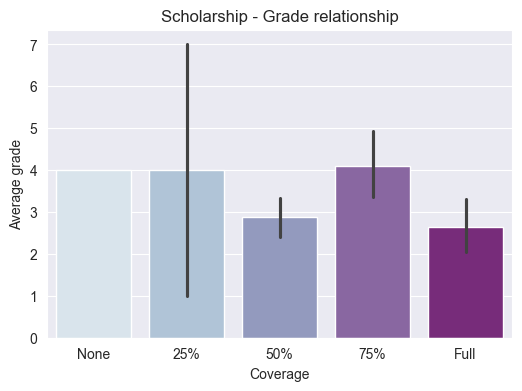

In [31]:
# Scholarship - grades 

fig = sns.barplot(data=df, x="sch_type", y= 'grade', palette='BuPu')

plt.title('Scholarship - Grade relationship')
plt.xticks(np.arange(0, 5, step=1), ['None', '25%', '50%', '75%', 'Full'])
plt.xlabel('Coverage')
plt.ylabel('Average grade')
plt.show()

- For some reason, students with full coverage have lower grades. This can be due other factors (social status, work, family economy...) But the ones with 50% coverage also score lower than the ones with none or smal coverage.
- Is also safe to point that the interval of confidence of students with 25%, tell us that there is less data to compute, therefore less confiable.
- Interestinly, the ones with 75% coverage are the ones with beter grades.

### Relationships with External Factors

- Does engagement in regular artistic or sports activities relate to academic performance?
- Is there a correlation between having a partner and academic performance?
- Do different levels of salary (if available) affect student performance?  

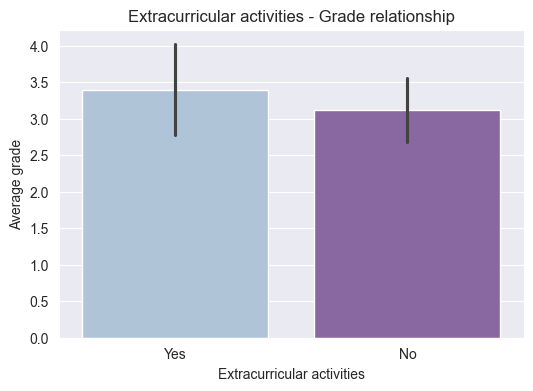

In [41]:
# Extracurricular - grades 

fig = sns.barplot(data=df, x="ex_act", y= 'grade', palette='BuPu')

plt.title('Extracurricular activities - Grade relationship')
plt.xticks(np.arange(0, 2, step=1), ['Yes', 'No'])
plt.xlabel('Extracurricular activities')
plt.ylabel('Average grade')
plt.show()

- The impact is low, but the students with external activities score better

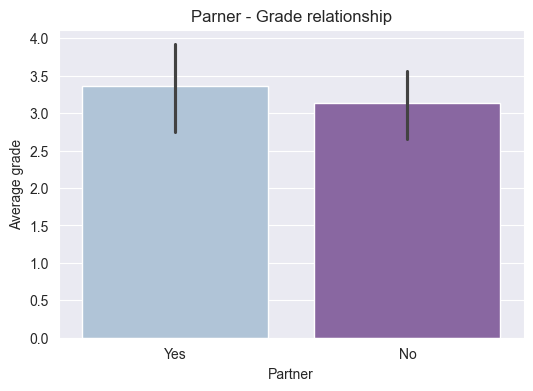

In [40]:
# Partner - grades 

fig = sns.barplot(data=df, x="partner", y= 'grade', palette='BuPu')

plt.title('Parner - Grade relationship')
plt.xticks(np.arange(0, 2, step=1), ['Yes', 'No'])
plt.xlabel('Partner')
plt.ylabel('Average grade')
plt.show()

- Here the impact is not that noticeable. Students with partner score better  
I think it might be interesting to see the distribuition by gender

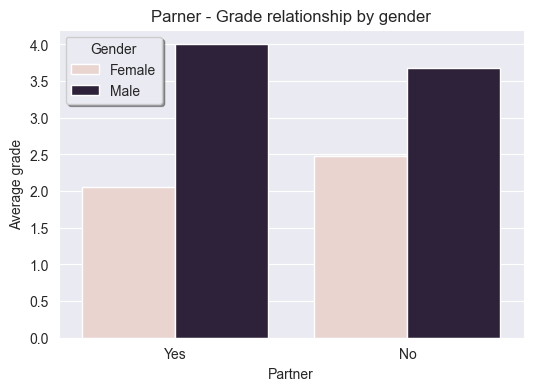

In [39]:
# Partner - grades 

fig = sns.barplot(data=df, x="partner", y= 'grade', hue='gender', ci=None)

plt.title('Parner - Grade relationship by gender')
plt.xticks(np.arange(0, 2, step=1), ['Yes', 'No'])
plt.xlabel('Partner')
plt.ylabel('Average grade')
plt.legend(title='Gender', labels = ['Female', 'Male'], shadow=True)
plt.show()

- Males with a partner score better than males without.
- Females without a partner are the ones that perform better than females with.

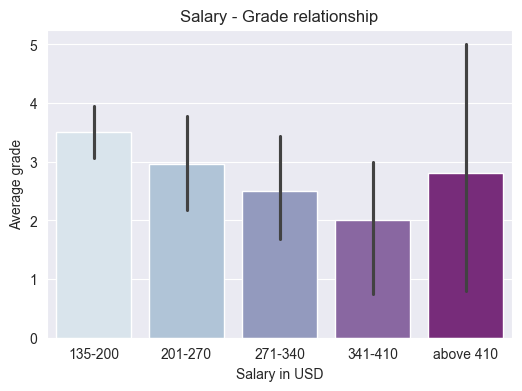

In [37]:
# Salary - grades 

fig = sns.barplot(data=df, x="salary", y= 'grade', palette='BuPu')

plt.title('Salary - Grade relationship')
plt.xticks(np.arange(0, 5, step=1), ['135-200', '201-270', '271-340', '341-410', 'above 410'])
plt.xlabel('Salary in USD')
plt.ylabel('Average grade')
plt.show()

- Students score lower the hiher the income is. 
- The exception is students with income above 410 USD but the error bar show us that the resulst are less reliables.

### Impact of Lifestyle and Study Habits

- How does the mode of transportation to the university affect academic performance?
- Does accommodation type in Cyprus influence academic performance?
- Do study hours per week correlate with academic performance?  

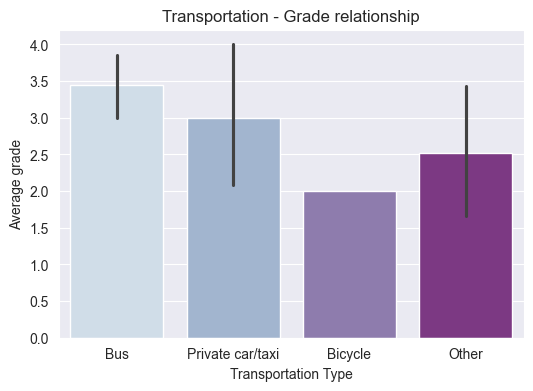

In [36]:
# Transportation - grades 

fig = sns.barplot(data=df, x="transp", y= 'grade', palette='BuPu')

plt.title('Transportation - Grade relationship')
plt.xticks(np.arange(0, 4, step=1), ['Bus', 'Private car/taxi', 'Bicycle', 'Other'])
plt.xlabel('Transportation Type')
plt.ylabel('Average grade')
plt.show()

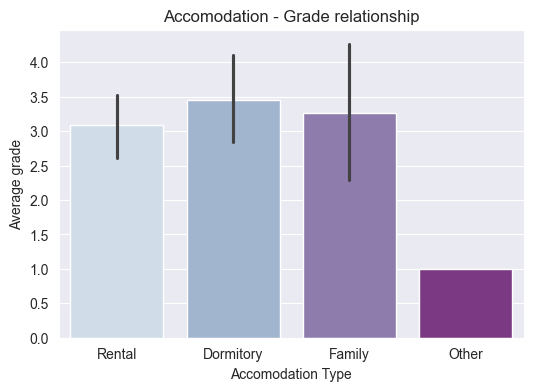

In [38]:
# accomodation type - grades 

fig = sns.barplot(data=df, x="acc_type", y= 'grade', palette='BuPu')

plt.title('Accomodation - Grade relationship')
plt.xticks(np.arange(0, 4, step=1), ['Rental', 'Dormitory', 'Family', 'Other'])
plt.xlabel('Accomodation Type')
plt.ylabel('Average grade')
plt.show()

- Accomodation doesn't seem to have a huge impact.

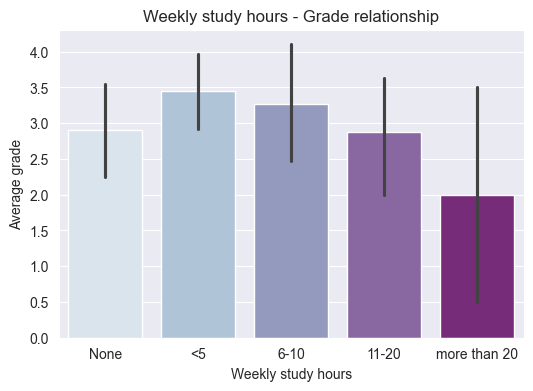

In [44]:
# Weekly study hours - grades 

fig = sns.barplot(data=df, x="w_hours", y= 'grade', palette='BuPu')

plt.title('Weekly study hours - Grade relationship')
plt.xticks(np.arange(0, 5, step=1), ['None', '<5', '6-10', '11-20', 'more than 20'])
plt.xlabel('Weekly study hours')
plt.ylabel('Average grade')
plt.show()

- Seems like the more hours the lower grade.
- Exception is the student's group with none hours.

### Family Background and Educational Influence

- Does the level of education of the mother or father affect student performance?
- Is there a relationship between the number of siblings and academic performance?
- How does parental status (married, divorced, deceased) relate to academic performance?  

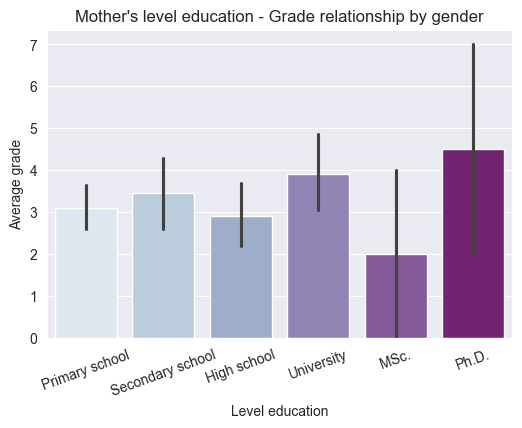

In [45]:
# Mother's level education - grades 

fig = sns.barplot(data=df, x="mo_edu", y= 'grade', palette='BuPu')

plt.title("Mother's level education - Grade relationship by gender")
plt.xticks(np.arange(0, 6, step=1), ['Primary school', 'Secondary school', 'High school', 
                                     'University', 'MSc.', 'Ph.D.'], rotation=20)
plt.xlabel('Level education')
plt.ylabel('Average grade')
plt.show()

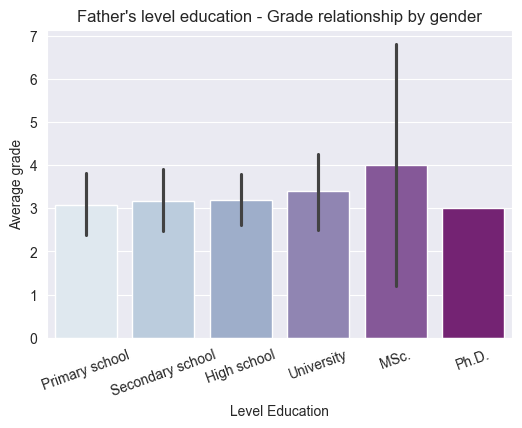

In [46]:
# Father's level education - grades 

fig = sns.barplot(data=df, x="fa_edu", y= 'grade', palette='BuPu')

plt.title("Father's level education - Grade relationship by gender")
plt.xticks(np.arange(0, 6, step=1), ['Primary school', 'Secondary school', 'High school', 
                                     'University', 'MSc.', 'Ph.D.'], rotation=20)
plt.xlabel('Level Education')
plt.ylabel('Average grade')
plt.show()

- Based on the two previous plots, the mother's education have has more impact  than the father's.

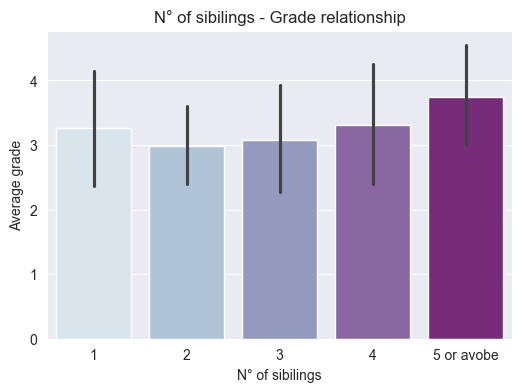

In [48]:
# N° of sibilings level education - grades 

fig = sns.barplot(data=df, x="n_sib", y= 'grade', palette='BuPu')

plt.title("N° of sibilings - Grade relationship")
plt.xticks(np.arange(0, 5, step=1), ['1', '2', '3', 
                                     '4', '5 or avobe'])
plt.xlabel('N° of sibilings')
plt.ylabel('Average grade')
plt.show()

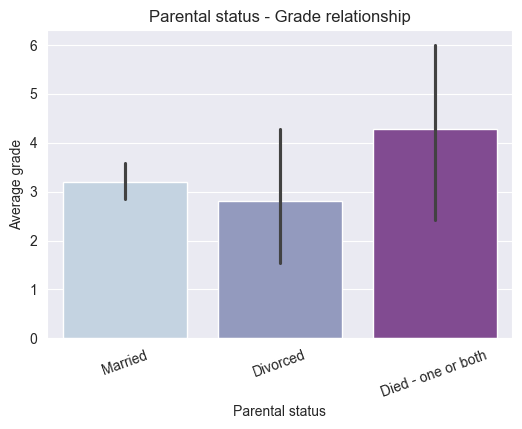

In [50]:
# Parental status - grades 

fig = sns.barplot(data=df, x="p_stus", y= 'grade', palette='BuPu')

plt.title("Parental status - Grade relationship")
plt.xticks(np.arange(0, 3, step=1), ['Married', 'Divorced', 'Died - one or both'], rotation=20)
plt.xlabel('Parental status')
plt.ylabel('Average grade')
plt.show()

- Interestingly, students with one or both parents deceased socre higher. Of course the error bar has to be taken into account.

### Occupational Influence

- Does the occupation of the mother or father influence student performance?

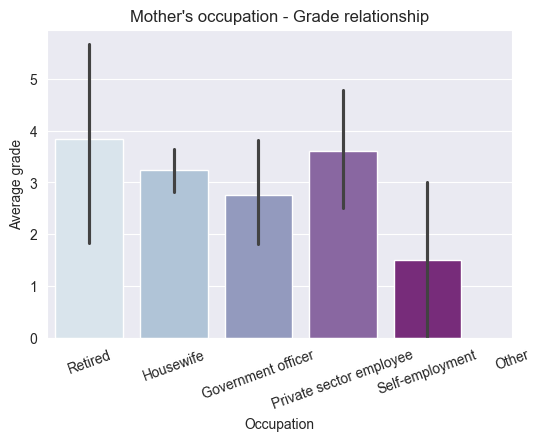

In [51]:
# Mother's occupation - grades 

fig = sns.barplot(data=df, x="mo_occ", y= 'grade', palette='BuPu')

plt.title("Mother's occupation - Grade relationship")
plt.xticks(np.arange(0, 6, step=1), ['Retired', 'Housewife', 'Government officer', 'Private sector employee', 
                                     'Self-employment', 'Other'], rotation=20)
plt.xlabel('Occupation')
plt.ylabel('Average grade')
plt.show()

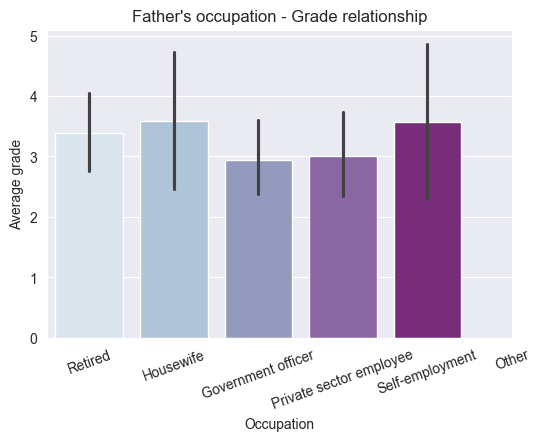

In [52]:
# Father's occupation - grades 

fig = sns.barplot(data=df, x="fa_occ", y= 'grade', palette='BuPu')

plt.title("Father's occupation - Grade relationship")
plt.xticks(np.arange(0, 6, step=1), ['Retired', 'Housewife', 'Government officer', 'Private sector employee', 
                                     'Self-employment', 'Other'], rotation=20)
plt.xlabel('Occupation')
plt.ylabel('Average grade')
plt.show()

- Father's occupation has more impact than mother's occupation

### Reading Habits and Academic Performance

- How do reading habits (frequency of reading non-scientific and scientific materials) correlate with academic performance?  

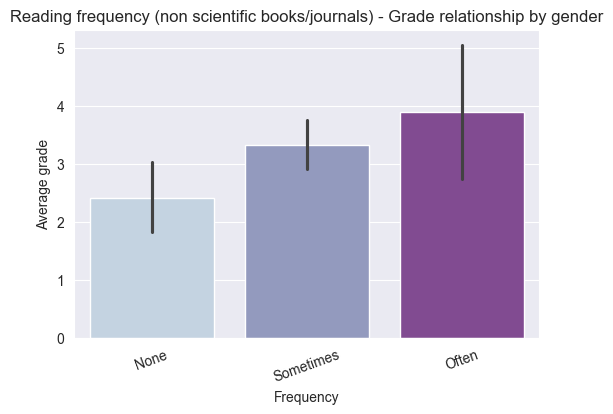

In [57]:
# Reading frequency non scientific - grades 

fig = sns.barplot(data=df, x="frec_nsci", y= 'grade', palette='BuPu')

plt.title("Reading frequency (non scientific books/journals) - Grade relationship by gender")
plt.xticks(np.arange(0, 3, step=1), ['None', 'Sometimes', 'Often'], rotation=20)
plt.xlabel('Frequency')
plt.ylabel('Average grade')
plt.show()

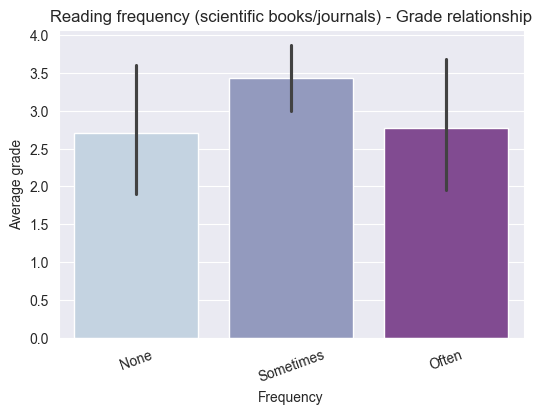

In [54]:
# Reading frequency scientific - grades 

fig = sns.barplot(data=df, x="frec_sci", y= 'grade', palette='BuPu')

plt.title("Reading frequency (scientific books/journals) - Grade relationship")
plt.xticks(np.arange(0, 3, step=1), ['None', 'Sometimes', 'Often'], rotation=20)
plt.xlabel('Frequency')
plt.ylabel('Average grade')
plt.show()

- Students who reads non scientific books have better grades that students who reads scintifis books.
- The difference is small though. 

### Target and feature split

In [62]:
X = df.drop(['id', 'grade'], axis=1)
y = df.grade

In [63]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (145, 31)
Shape of y: (145,)


We have 145 features in total. Lets reduce them.

### Selecting best features

#### Using a Decision Tree Classifier for feature selection

In [64]:
# Defining and fitting the model
selector = DecisionTreeClassifier()
selector.fit(X, y)

# Getting importance
importance = selector.feature_importances_

# Summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.02766
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.02231
Feature: 4, Score: 0.01704
Feature: 5, Score: 0.02039
Feature: 6, Score: 0.04700
Feature: 7, Score: 0.01352
Feature: 8, Score: 0.02202
Feature: 9, Score: 0.04083
Feature: 10, Score: 0.03236
Feature: 11, Score: 0.04658
Feature: 12, Score: 0.02704
Feature: 13, Score: 0.01552
Feature: 14, Score: 0.02223
Feature: 15, Score: 0.11011
Feature: 16, Score: 0.03037
Feature: 17, Score: 0.01246
Feature: 18, Score: 0.02028
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.02482
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.03917
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.02983
Feature: 25, Score: 0.05332
Feature: 26, Score: 0.01198
Feature: 27, Score: 0.04948
Feature: 28, Score: 0.09268
Feature: 29, Score: 0.01475
Feature: 30, Score: 0.15626


In [65]:
# Creating a dataset with the festure's score and the column's names

best_features= pd.DataFrame(data={'feature':X.columns,'relevance':selector.feature_importances_})
best_features= best_features.sort_values(by='relevance',ascending=False)

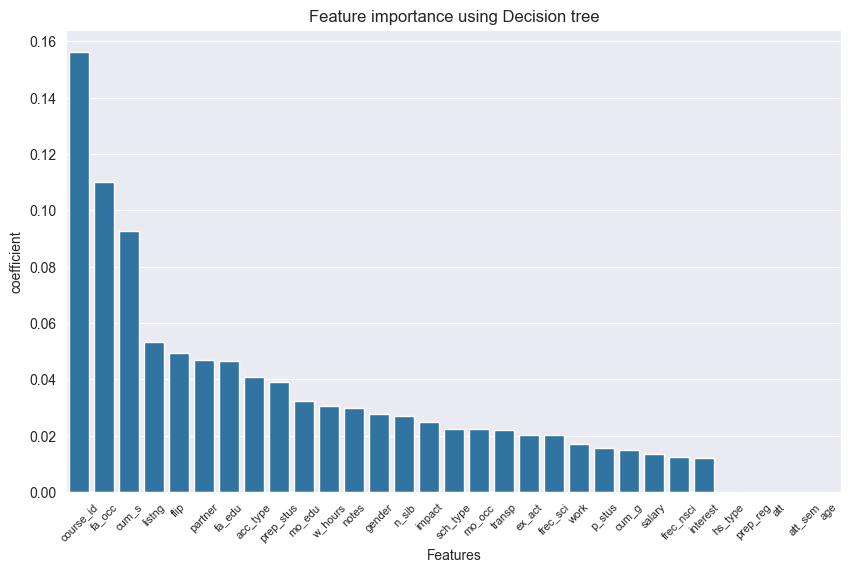

In [67]:
# Features importance

fig = plt.figure(figsize=(10, 6))
fig = sns.barplot(data=best_features, x="feature", y= 'relevance', ci=None)

plt.title("Feature importance using Decision tree")
plt.xlabel('Features')
plt.xticks(rotation=45, size=8)
plt.ylabel("coefficient")
plt.show()


In [88]:
# Selecting those features with score >= 0.04

df_feat = best_features[(best_features['relevance'] >= 0.05) ]
df_feat

,feature,relevance
30,course_id,0.156258
15,fa_occ,0.110107
28,cum_s,0.092675
25,listng,0.053318


In [89]:
df_feat.feature.shape

(4,)

Now we have 4 features that explain what affects the most to students:
- Course_id
- Father's occupation
- Cumulative grade point last semester
- Listening in class

Some of them have already been ploted, let see the rest of them

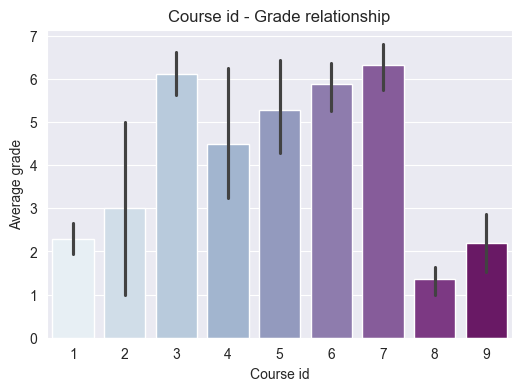

In [83]:
# Course id - grades 

fig = sns.barplot(data=df, x="course_id", y= 'grade', palette='BuPu')

plt.title("Course id - Grade relationship")
plt.xticks(np.arange(0, 9, step=1))#, ['None', 'Sometimes', 'Often'], rotation=20)
plt.xlabel('Course id')
plt.ylabel('Average grade')
plt.show()

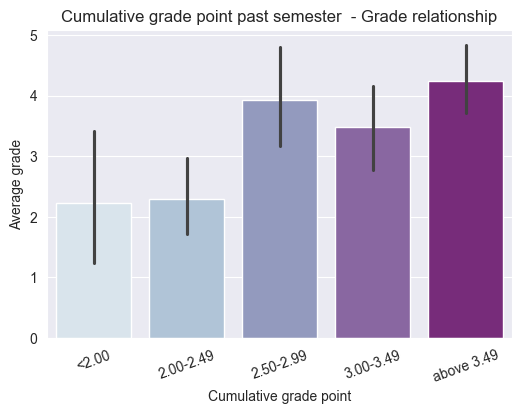

In [85]:
# Cumulative grade past semester - grades 

fig = sns.barplot(data=df, x="cum_s", y= 'grade', palette='BuPu')

plt.title("Cumulative grade point past semester  - Grade relationship")
plt.xticks(np.arange(0, 5, step=1), ['<2.00', '2.00-2.49', '2.50-2.99', '3.00-3.49', 'above 3.49'], rotation=20)
plt.xlabel('Cumulative grade point')
plt.ylabel('Average grade')
plt.show()

- The higher the grade point was, the better grades will the student have.

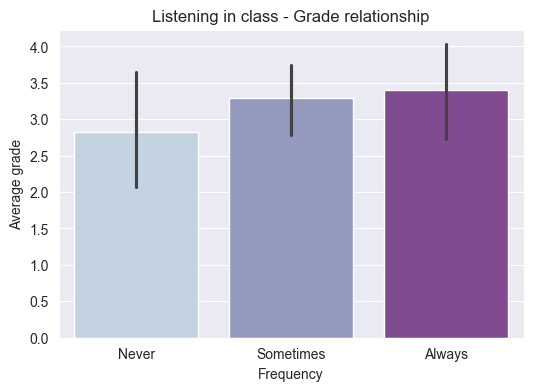

In [86]:
# Listening in class - grades 

fig = sns.barplot(data=df, x="listng", y= 'grade', palette='BuPu')

plt.title("Listening in class - Grade relationship")
plt.xticks(np.arange(0, 3, step=1), ['Never', 'Sometimes', 'Always'])
plt.xlabel('Frequency')
plt.ylabel('Average grade')
plt.show()

In [90]:
df_feat.feature.values

array(['course_id', 'fa_occ', 'cum_s', 'listng'], dtype=object)

In [92]:
# Re-defining X and y 

X = df[['course_id', 'fa_occ', 'cum_s', 'listng']]
y = df['grade']

#### Target distribuition

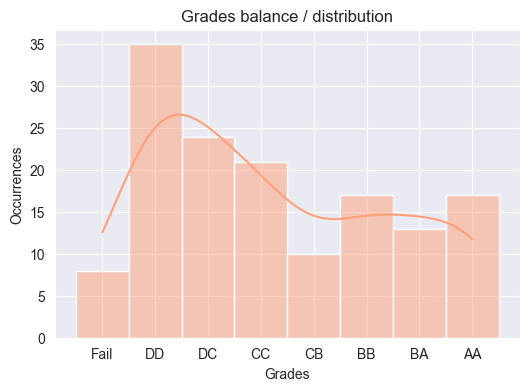

In [73]:
# Grade distribuition

sns.histplot(y, bins=8, color='lightsalmon', discrete=True,kde=True)

plt.title('Grades balance / distribution')
plt.xlabel('Grades')
plt.ylabel('Occurrences')
plt.xticks(np.arange(0, 8, step=1), ['Fail', 'DD', 'DC', 'CC', 'CB', 'BB', 'BA', 'AA'])

plt.show()

In [93]:
y.value_counts()

grade
1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: count, dtype: int64

The Target is very umbalanced. Therefore I will transform it into a binary target: Pass or Fail

### Predicting if students will pass or fail

#### Creating binary target

In [94]:
# Mapping grades as a binary output: 0= Fail, 1= Pass

y = y.map({0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1})

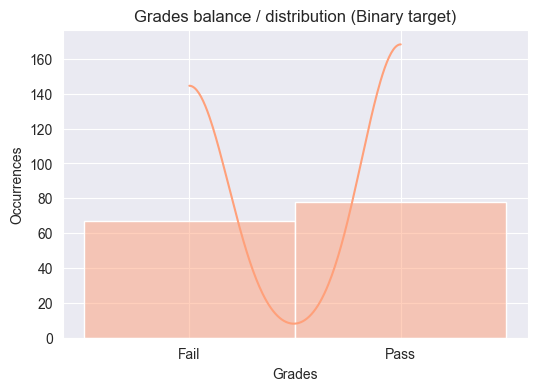

In [95]:
# Grade distribuition

sns.histplot(y, bins=2, color='lightsalmon', discrete=True,kde=True)

plt.title('Grades balance / distribution (Binary target)')
plt.xlabel('Grades')
plt.ylabel('Occurrences')
plt.xticks(np.arange(0, 2, step=1), ['Fail', 'Pass'])

plt.show()

In [136]:
# Data split with new y values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)

In [194]:
# Oversampling data

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=300, n_features=4,
                           n_classes=2, n_informative=2,
                           random_state=RSEED)
sm = SMOTE(random_state=RSEED)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_test, y_test = make_classification(n_samples=40,n_features=4,
                           n_classes=2, n_informative=2,
                           random_state=RSEED)
sm = SMOTE(random_state=RSEED)
X_test, y_test = sm.fit_resample(X_test, y_test)

from collections import Counter
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_test).items()))

[(0, 151), (1, 151)]
[(0, 21), (1, 21)]


In [164]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (302, 4)
X_test shape: (42, 4)
y_train shape: (302,)
y_test shape: (42,)


### Logistic regression as baseline model

In [165]:
# Create a logistic regression model

baseline_lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RSEED) 


In [166]:
# Train the model
baseline_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [167]:
# Make predictions on the test set
y_pred = baseline_lr.predict(X_test)

In [168]:
# Predicting on train data 
y_train_pred = baseline_lr.predict(X_train)

# Testing predictions (to determine performance)
y_pred = baseline_lr.predict(X_test)

### Results on Training data

Accuracy : 0.92
Recall : 0.92
Precision: 0.92
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.92      0.92      0.92       151
           1       0.92      0.92      0.92       151

    accuracy                           0.92       302
   macro avg       0.92      0.92      0.92       302
weighted avg       0.92      0.92      0.92       302



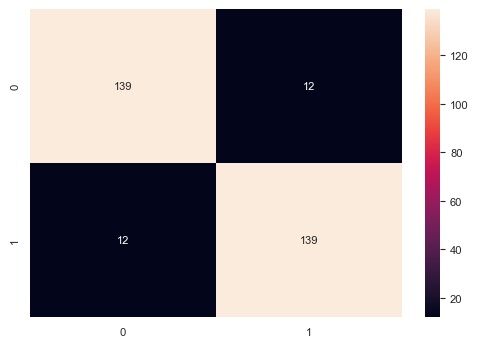

In [169]:
print('Accuracy : {:.2f}'.format(accuracy_score(y_train, y_train_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, y_train_pred)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, y_train_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt = 'd')
plt.rcParams['font.size'] = 8

plt.show()

### Results on Test data

Accuracy : 0.95
Recall : 0.95
Precision: 0.95
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.95      0.95        21

    accuracy                           0.95        42
   macro avg       0.95      0.95      0.95        42
weighted avg       0.95      0.95      0.95        42



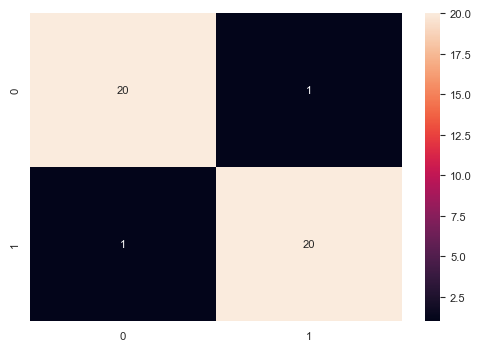

In [170]:
#
# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, y_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'd')
plt.rcParams['font.size'] = 8

plt.show()

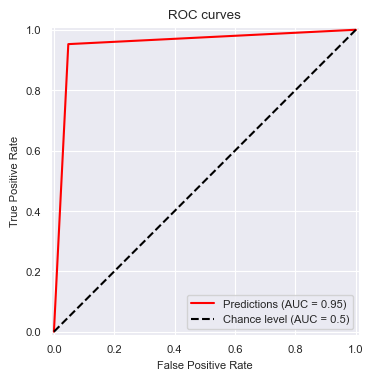

In [171]:
# ROC Curve plot

display = RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name="Predictions",
    color="red",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves")

### Training a random forest model

In [175]:
# Checking the best ccp_alpha values

dt = DecisionTreeClassifier()

path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)
print(ccp_alphas[5])
print(ccp_alphas[8])
#print(ccp_alphas[9])
#print(ccp_alphas[10])

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3628632175761871
0.006340919571450809
0.3628632175761871


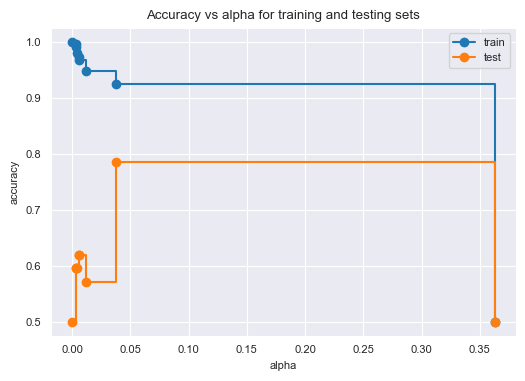

In [176]:
# Plotting the best ccp_alpha values

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()


In [177]:
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier())
])


In [178]:
param_rf = {
                'rf__n_estimators': [100],
                'rf__max_features': ['sqrt'],
                'rf__max_depth': [2, 4, 6],
                'rf__max_leaf_nodes':[20, 25, 30, 35, 40],
                'rf__ccp_alpha':[0.004, 0.005, 0.006, 0.007],
                'rf__random_state': [RSEED],
                'rf__criterion': ['gini'],
                'rf__bootstrap': [False],
               }


grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring= ['recall', 'precision', 'accuracy'], 
                           refit='accuracy', verbose=5, n_jobs=-1)

In [179]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__bootstrap': [False],
                         'rf__ccp_alpha': [0.004, 0.005, 0.006, 0.007],
                         'rf__criterion': ['gini'], 'rf__max_depth': [2, 4, 6],
                         'rf__max_features': ['sqrt'],
                         'rf__max_leaf_nodes': [20, 25, 30, 35, 40],
                         'rf__n_estimators': [100], 'rf__random_state': [42]},
             refit='accuracy', scoring=['recall', 'precision', 'accuracy'],
             verbose=5)

In [180]:
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.95
Best parameters:
{'rf__bootstrap': False, 'rf__ccp_alpha': 0.007, 'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__max_leaf_nodes': 20, 'rf__n_estimators': 100, 'rf__random_state': 42}


In [181]:
best_model_rf = grid_rf.best_estimator_
best_model_rf

Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.007,
                                        max_depth=6, max_leaf_nodes=20,
                                        random_state=42))])

In [182]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = best_model_rf.predict(X_train)

# Testing predictions (to determine performance)
rf_predictions = best_model_rf.predict(X_test)

### Results on Training set

Accuracy : 0.97
Recall : 0.97
Precision: 0.97
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.97      0.97       151
           1       0.97      0.97      0.97       151

    accuracy                           0.97       302
   macro avg       0.97      0.97      0.97       302
weighted avg       0.97      0.97      0.97       302



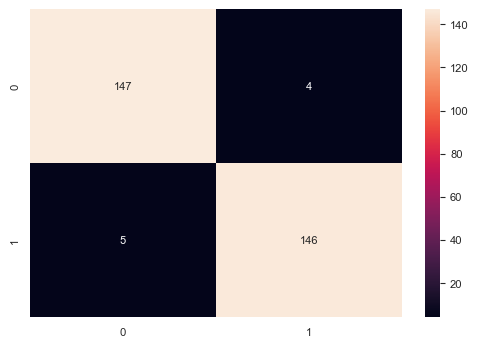

In [183]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_rf_predictions)))
print("Precision: {:.2f}".format(precision_score(y_train, train_rf_predictions)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_rf_predictions), annot=True, fmt = 'd')

plt.rcParams['font.size'] = 8

plt.show()

### Results on test set

Accuracy : 0.60
Recall : 0.86
Precision: 0.56
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.70      0.33      0.45        21
           1       0.56      0.86      0.68        21

    accuracy                           0.60        42
   macro avg       0.63      0.60      0.57        42
weighted avg       0.63      0.60      0.57        42



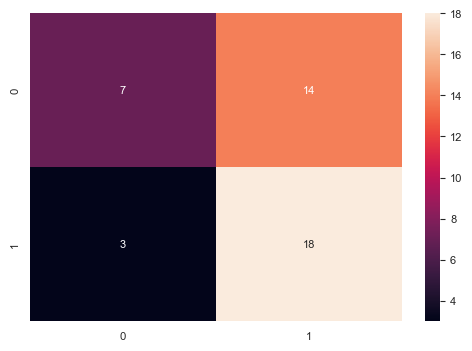

In [184]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, rf_predictions)))
print("Precision: {:.2f}".format(precision_score(y_test, rf_predictions)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt = 'd')

plt.rcParams['font.size'] = 8

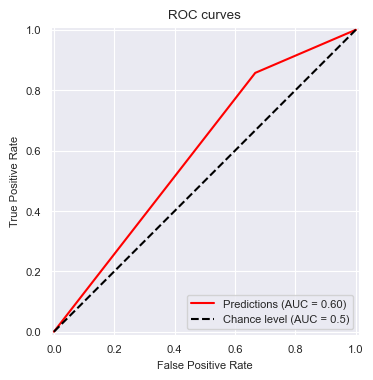

In [185]:
# ROC Curve plot

display = RocCurveDisplay.from_predictions(
    y_test,
    rf_predictions,
    name="Predictions",
    color="red",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves")

### Training a SVM model

In [186]:
from sklearn import svm 

In [187]:
#Create a svm Classifier
svm_classifier= svm.SVC(kernel='sigmoid', gamma='scale')

#Train the model
svm_classifier_model=svm_classifier.fit(X_train, y_train)


In [188]:
# Training predictions (to demonstrate overfitting)
svm_train_predictions = svm_classifier_model.predict(X_train)

# Testing predictions (to evaluate performance)
svm_predictions = svm_classifier_model.predict(X_test)

Accuracy : 0.90
Recall : 0.89
Precision: 0.90
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.89      0.90      0.90       151
           1       0.90      0.89      0.90       151

    accuracy                           0.90       302
   macro avg       0.90      0.90      0.90       302
weighted avg       0.90      0.90      0.90       302



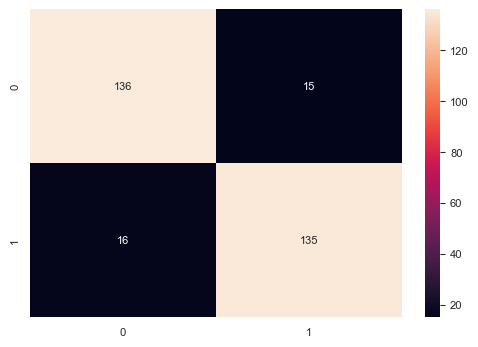

In [189]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_train, svm_train_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, svm_train_predictions)))
print("Precision: {:.2f}".format(precision_score(y_train, svm_train_predictions)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, svm_train_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, svm_train_predictions), annot=True, fmt = 'd')

plt.show()

#### Results on test data

Accuracy : 0.90
Recall : 0.86
Precision: 0.95
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.95      0.86      0.90        21

    accuracy                           0.90        42
   macro avg       0.91      0.90      0.90        42
weighted avg       0.91      0.90      0.90        42



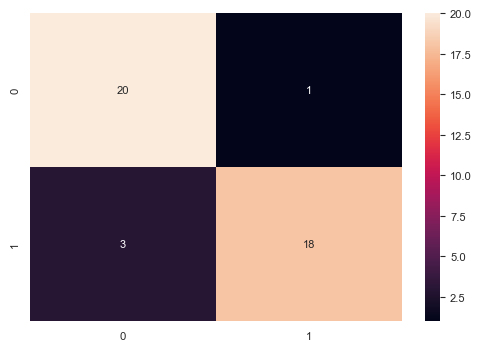

In [190]:
# Printing results

print('Accuracy : {:.2f}'.format(accuracy_score(y_test, svm_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, svm_predictions)))
print("Precision: {:.2f}".format(precision_score(y_test, svm_predictions)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, svm_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, svm_predictions), annot=True, fmt = 'd')

plt.show()

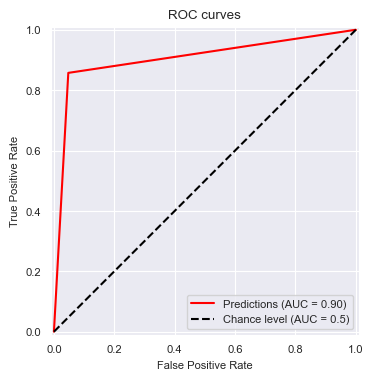

In [191]:
# ROC Curve plot

display = RocCurveDisplay.from_predictions(
    y_test,
    svm_predictions,
    name="Predictions",
    color="red",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curves")